In [1]:
# !pip install -q git+https://github.com/matjesg/deepflash2.git

In [2]:
# !pip install zarr

In [3]:
# imports
import zarr, cv2
import numpy as np, pandas as pd, segmentation_models_pytorch as smp
from deepflash2.all import *
from deepflash2.transforms import random_center
import albumentations as alb
import torch
import torch.nn as nn

In [4]:
from config.global_vars import *

In [5]:
ARCH = 'linknet'

In [6]:
# Model
model = smp.Linknet(encoder_name=ENCODER_NAME, 
                 encoder_weights=ENCODER_WEIGHTS, 
                 in_channels=CHANNELS, 
                 classes=CLASSES)
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
model.cuda();

Let's use 2 GPUs!


In [7]:
from fastai.vision.all import *

In [8]:
@patch
def read_img(self:BaseDataset, file, *args, **kwargs):
    return zarr.open(str(file), mode='r')

@patch
def _name_fn(self:BaseDataset, g):
    "Name of preprocessed and compressed data."
    return f'{g}'

@patch
def apply(self:DeformationField, data, offset=(0, 0), pad=(0, 0), order=1):
    "Apply deformation field to image using interpolation"
    outshape = tuple(int(s - p) for (s, p) in zip(self.shape, pad))
    coords = [np.squeeze(d).astype('float32').reshape(*outshape) for d in self.get(offset, pad)]
    # Get slices to avoid loading all data (.zarr files)
    sl = []
    for i in range(len(coords)):
        cmin, cmax = int(coords[i].min()), int(coords[i].max())
        dmax = data.shape[i]
        if cmin<0: 
            cmax = max(-cmin, cmax)
            cmin = 0 
        elif cmax>dmax:
            cmin = min(cmin, 2*dmax-cmax)
            cmax = dmax
            coords[i] -= cmin
        else: coords[i] -= cmin
        sl.append(slice(cmin, cmax))    
    if len(data.shape) == len(self.shape) + 1:
        tile = np.empty((*outshape, data.shape[-1]))
        for c in range(data.shape[-1]):
            # Adding divide
            tile[..., c] = cv2.remap(data[sl[0],sl[1], c]/255, coords[1],coords[0], interpolation=order, borderMode=cv2.BORDER_REFLECT)
    else:
        tile = cv2.remap(data[sl[0], sl[1]], coords[1], coords[0], interpolation=order, borderMode=cv2.BORDER_REFLECT)
    return tile

In [9]:
@patch
def __getitem__(self:RandomTileDataset, idx):
    idx = idx % len(self.files)
    if torch.is_tensor(idx):
        idx = idx.tolist()

    img_path = self.files[idx]
    img = self.read_img(img_path, divide=self.divide)
    n_channels = img.shape[-1]

    lbl, pdf  = self.labels[img_path.name], self.pdfs[self._name_fn(img_path.name)]
    center = random_center(pdf[:], lbl.shape, TILE_SHAPE)
    X = self.gammaFcn(self.deformationField.apply(img, center).flatten()).reshape((*self.tile_shape, n_channels))
    Y = self.deformationField.apply(lbl, center, self.padding, 0)
    X1 = X.copy()

    if self.albumentations_tfms:
        augmented = self.albumentations_tfms(image=(X*255).astype('uint8'),mask=Y.astype('uint8'))
        X = (augmented['image']/255)
        Y = augmented['mask']

    X = X.transpose(2, 0, 1).astype('float32')
    Y = Y.astype('int64')

    if self.loss_weights:
        _, W = cv2.connectedComponents((Y > 0).astype('uint8'), connectivity=4)
        return  TensorImage(X), TensorMask(Y), torch.Tensor(W)
    else:
        return  TensorImage(X), TensorMask(Y)

In [10]:
@patch
def _do_one_batch(self:Learner):
    self.pred = self.model(*self.xb)
    self('after_pred')
    if len(self.yb):
        self.loss_grad = self.loss_func(self.pred, *self.yb)
        self.loss = self.loss_grad.clone()
    self('after_loss')
    if not self.training or not len(self.yb): return
    self('before_backward')
    self.loss_grad.backward()
    self._with_events(self.opt.step, 'step', CancelStepException)
    self.opt.zero_grad()

### Configuration

In [11]:
class CONFIG():
    
    # data paths
    data_path = Path('/home/jupyter/data_2/')
    data_path_zarr = Path('/home/jupyter/train_scale2')
    mask_preproc_dir = '/home/jupyter/masks_scale2'
    
    # deepflash2 dataset
    # scale = 1.5 # data is already downscaled to 2, so absulute downscale is 3
    scale = 1 # data is already downscaled to 2, so absulute downscale is 3
    tile_shape = (TILE_SHAPE, TILE_SHAPE)
    padding = (0,0) # Border overlap for prediction
    n_jobs = NUM_WORKERS
    sample_mult = 200 # Sample 100 tiles from each image, per epoch
    val_length = 500 # Randomly sample 500 validation tiles
    stats = np.array([0.61561477, 0.5179343 , 0.64067212]), np.array([0.2915353 , 0.31549066, 0.28647661])
    
    # deepflash2 augmentation options
    zoom_sigma = 0.1
    flip = True
    max_rotation = 360
    deformation_grid_size = (150,150)
    deformation_magnitude = (10,10)

    # pytorch model (segmentation_models_pytorch)
    encoder_name = ENCODER_NAME
    encoder_weights = ENCODER_WEIGHTS
    in_channels = 3
    classes = 2
    
    # fastai Learner 
    mixed_precision_training = True
    batch_size = 12
    weight_decay = 0.01
    loss_func = CrossEntropyLossFlat(axis=1)
    metrics = [Iou(), Dice_f1()]
    optimizer = ranger
    max_learning_rate = 1e-2
    epochs = 15
    
cfg = CONFIG()

In [12]:
# Albumentations augmentations
# Inspired by https://www.kaggle.com/iafoss/hubmap-pytorch-fast-ai-starter
# deepflash2 augmentations are only affine transformations
tfms = alb.OneOf([
    alb.HueSaturationValue(10,15,10),
    alb.CLAHE(clip_limit=2),
    alb.RandomBrightnessContrast(),          
], p=0.3)

In [13]:
df_train = pd.read_csv(cfg.data_path/'train.csv')
df_info = pd.read_csv(cfg.data_path/'HuBMAP-20-dataset_information.csv')

files = [x for x in cfg.data_path_zarr.iterdir() if x.is_dir() if not x.name.startswith('.')]
label_fn = lambda o: o

In [14]:
!ls {cfg.mask_preproc_dir}

labels	pdfs


### Training

In [15]:
# Datasets
ds_kwargs = {
    'tile_shape':cfg.tile_shape,
    'padding':cfg.padding,
    'scale': cfg.scale,
    'n_jobs': cfg.n_jobs, 
    'preproc_dir': cfg.mask_preproc_dir, 
    'val_length':cfg.val_length, 
    'sample_mult':cfg.sample_mult,
    'loss_weights':False,
    'zoom_sigma': cfg.zoom_sigma,
    'flip' : cfg.flip,
    'max_rotation': cfg.max_rotation,
    'deformation_grid_size' : cfg.deformation_grid_size,
    'deformation_magnitude' : cfg.deformation_magnitude,
    'albumentations_tfms': tfms
}

train_ds = RandomTileDataset(files, label_fn=label_fn, **ds_kwargs)
valid_ds = TileDataset(files, label_fn=label_fn, **ds_kwargs, is_zarr=True)

Using preprocessed masks from /home/jupyter/masks_scale2
Using preprocessed masks from /home/jupyter/masks_scale2


In [16]:
image, mask = train_ds[0]

In [17]:
image = image.unsqueeze(0)
image.shape

torch.Size([1, 3, 768, 768])

In [18]:
cross_entropy = CrossEntropyLossFlat(axis=1)

def loss_fn(y_pred, targets, eps = 1e-7):
    true_1_hot = torch.eye(2)[targets]
    true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
    probas = F.softmax(y_pred, dim=1)
    true_1_hot = true_1_hot.type(y_pred.type())
    dims = (0,) + tuple(range(2, targets.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    dice_loss = (2. * intersection / (cardinality + eps)).mean()
    loss_weight = 0.2
    ce_loss = cross_entropy(y_pred, targets)
    return (1 - dice_loss) * loss_weight + ce_loss * (1 - loss_weight)

In [19]:
# Dataloader and learner
dls = DataLoaders.from_dsets(train_ds, valid_ds, bs=cfg.batch_size, after_batch=Normalize.from_stats(*cfg.stats))
if torch.cuda.is_available(): dls.cuda(), model.cuda()
cbs = [SaveModelCallback(monitor='iou'), ElasticDeformCallback]
learn = Learner(dls, model, metrics=cfg.metrics, wd=cfg.weight_decay, loss_func=loss_fn, opt_func=ranger, cbs=cbs)
if cfg.mixed_precision_training: learn.to_fp16()

SuggestedLRs(lr_min=0.05248074531555176, lr_steep=0.02290867641568184)

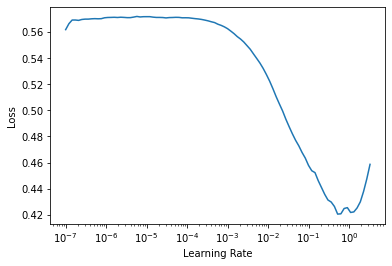

In [20]:
learn.lr_find()

In [ ]:
# Fit
learn.fit_one_cycle(cfg.epochs, lr_max=cfg.max_learning_rate)
learn.recorder.plot_metrics()

epoch,train_loss,valid_loss,iou,dice_f1,time
0,0.162178,0.094878,0.779495,0.876086,06:26
1,0.047936,0.061426,0.730802,0.844466,06:24
2,0.039207,0.059565,0.734764,0.847105,06:23
3,0.040578,0.088036,0.615819,0.762237,06:23
4,0.034017,0.054001,0.762176,0.865040,06:24
5,0.029688,0.047651,0.820251,0.901251,06:23
6,0.030581,0.044564,0.850129,0.918995,06:23
7,0.027923,0.061456,0.848932,0.918294,06:23
8,0.023730,0.041675,0.867104,0.928823,06:23
9,0.025063,0.041781,0.871524,0.931352,06:23


Better model found at epoch 0 with iou value: 0.7794953678209187.
Better model found at epoch 5 with iou value: 0.8202513899290603.
Better model found at epoch 6 with iou value: 0.8501294435600524.
Better model found at epoch 8 with iou value: 0.8671044626120457.
Better model found at epoch 9 with iou value: 0.8715237068950268.
Better model found at epoch 10 with iou value: 0.8825475310112079.
Better model found at epoch 12 with iou value: 0.882768928304441.


In [ ]:
!mv models/model.pth models/hubmap_pdf_sample_dice_loss_{ARCH}_{ENCODER_NAME}_b{cfg.batch_size}.pth